In [1]:
import os
os.chdir("..")

<h3> Load Libraries </h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.metrics import get_error_stats
from production.plots import plot_adaptive_evolution

<h3> Preprocess data </h3>

In [3]:
watershed_name = "Trinity"

In [ ]:
watershed = Preprocessor(config_path = f"/workspaces/Importance-Sampling-for-SST/data/0_source/{watershed_name}/config.json", 
                       output_folder = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}")
watershed.run()

In [4]:
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")

<h3> Full Monte Samples </h3>

In [5]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=20_000,
    num_realizations=50,
)

fullmonte_samples = sampler.sample(data = watershed)

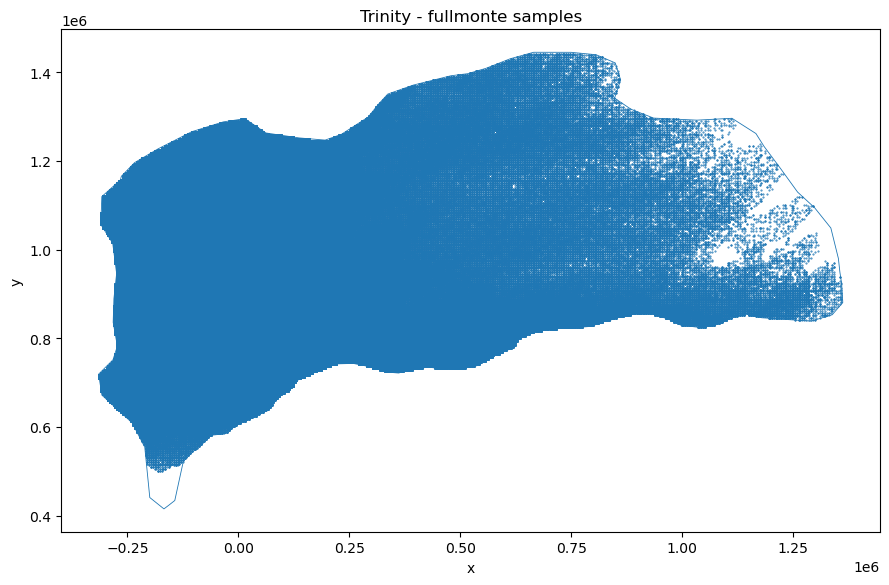

In [6]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(fullmonte_samples.newx, fullmonte_samples.newy, s=0.2, alpha=1, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - fullmonte samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [7]:
fullmonte_depths = StormDepthProcessor(watershed).run(fullmonte_samples, n_jobs=-1)

In [8]:
fullmonte_depths

,event_id,storm_path,x,y,weight,precip_avg_mm,realization,realization_seed,exc_prb
0,1,20130223_72hr_st1_r186,50953.464725,8.495487e+05,0.00005,78.980095,1,1.138469e+19,0.17575
1,2,19940209_72hr_st1_r234,166953.464725,1.205549e+06,0.00005,67.622017,1,1.138469e+19,0.30170
2,3,20090326_72hr_st1_r034,478953.464725,9.055487e+05,0.00005,76.382957,1,1.138469e+19,0.20020
3,4,20041008_72hr_st1_r013,-193046.535275,9.895487e+05,0.00005,140.369965,1,1.138469e+19,0.00980
4,5,19950703_72hr_st3_r400,-209046.535275,9.175487e+05,0.00005,55.619976,1,1.138469e+19,0.47790
...,...,...,...,...,...,...,...,...,...
999995,19996,19970228_72hr_st1_r312,-265046.535275,9.575487e+05,0.00005,62.288422,50,3.127773e+18,0.39005
999996,19997,19910525_72hr_st3_r174,-161046.535275,1.153549e+06,0.00005,70.360939,50,3.127773e+18,0.27460
999997,19998,20050709_72hr_st2_r037,354953.464725,9.495487e+05,0.00005,73.221741,50,3.127773e+18,0.24085
999998,19999,20170621_72hr_st2_r077,418953.464725,8.135487e+05,0.00005,37.383751,50,3.127773e+18,0.69335


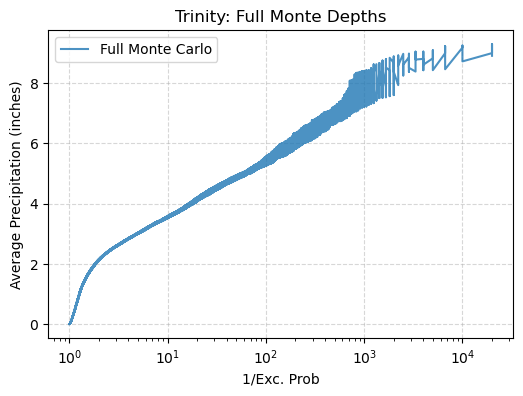

In [9]:
df_sorted = fullmonte_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))
plt.plot(
    1 / df_sorted["exc_prb"],  
    df_sorted["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")  # updated units
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Full Monte Depths")
plt.show()

In [10]:
#Save
fullmonte_depths.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

In [11]:
#Read
fullmonte_depths = pd.read_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

<h3> Importance Sampling - Truncated Normals </h3>

In [28]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*0.7,
    "sd_y": watershed.watershed_stats["range_y"]*0.3,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=10_000,
    num_realizations=50,
)

TruncNorm_samples = sampler.sample(data = watershed)

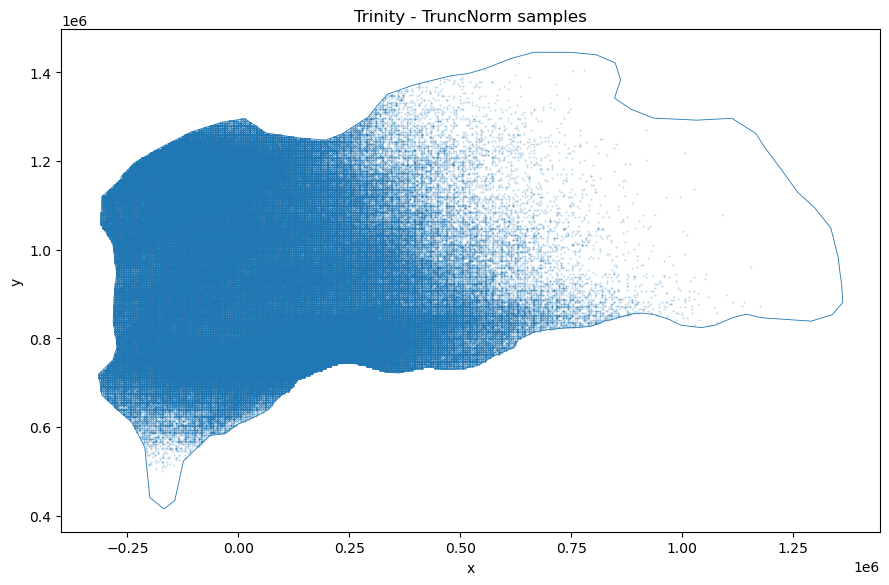

In [29]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(TruncNorm_samples.newx, TruncNorm_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - TruncNorm samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [30]:
TruncNorm_depths = StormDepthProcessor(watershed).run(TruncNorm_samples, n_jobs=-1)

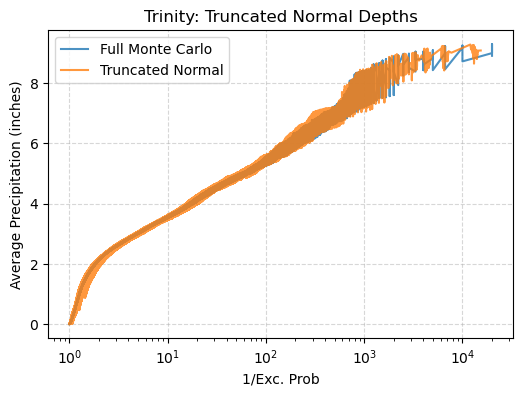

In [31]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Truncated Normal"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Truncated Normal Depths")
plt.show()

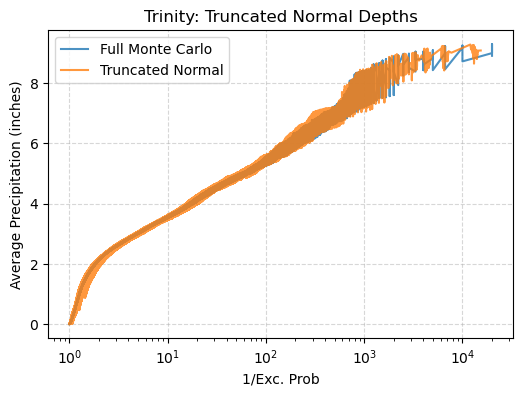

In [32]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Truncated Normal"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Truncated Normal Depths")
plt.show()

<h3> Importance Sampling - Gaussian Copula </h3>

In [42]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

copula_samples = sampler.sample(data = watershed)

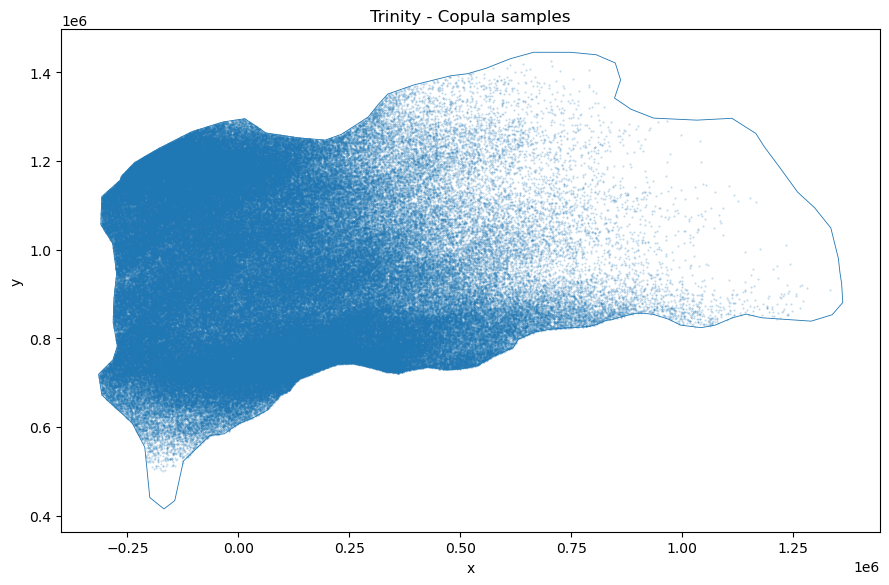

In [45]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [47]:
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

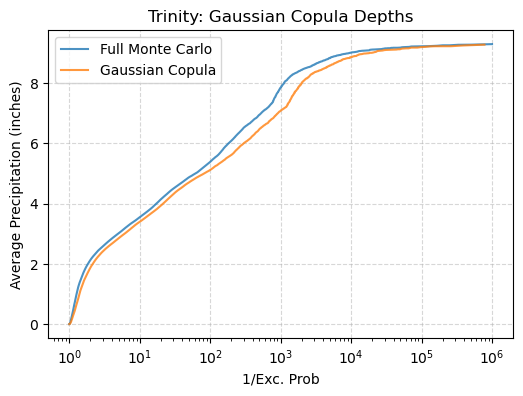

In [48]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Gaussian Copula"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Gaussian Copula Depths")
plt.show()

<h3> Importance Sampling - Mixture</h3>

In [65]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.1,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.1,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.3,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=6_000,
    num_rep=1,
)

mixture_samples = sampler.sample(data = watershed)

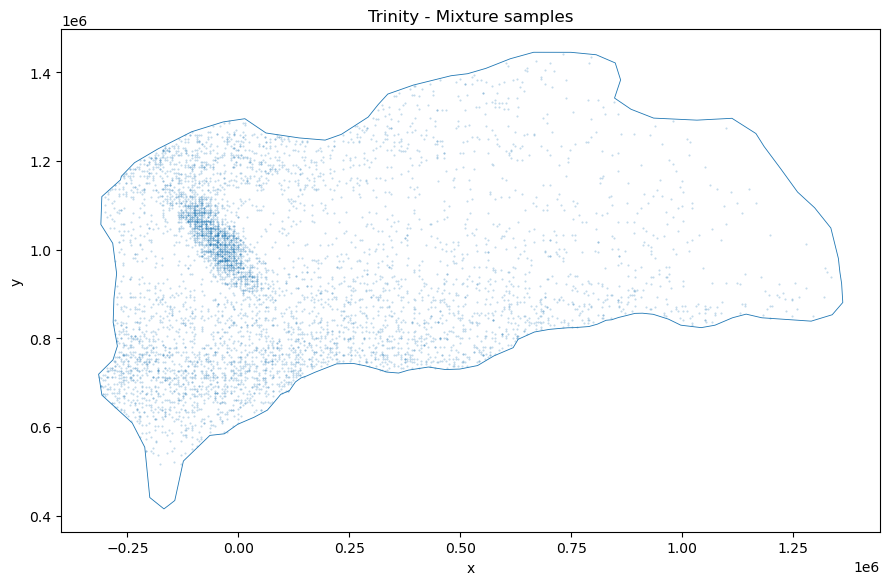

In [66]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Mixture samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [67]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

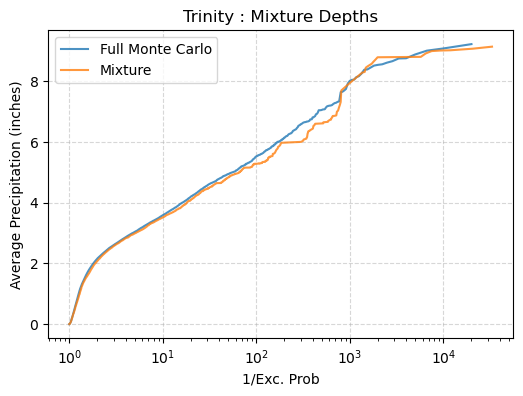

In [68]:
import matplotlib.pyplot as plt

# Sort both datasets by exceedance probability
df_full = fullmonte_depths.sort_values("exc_prb")
df_mixture = mixture_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))

# Full Monte Carlo
plt.plot(
    1 / df_full["exc_prb"], 
    df_full["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

# Truncated Normal
plt.plot(
    1 / df_mixture["exc_prb"], 
    df_mixture["precip_avg_mm"] / 25.4,
    label="Mixture",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name} : Mixture Depths") 
plt.show() 

<h3> Importance Sampling - Adaptive Mixture </h3>

In [ ]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"]*0.5,
    sd_y_n=watershed.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=watershed.cumulative_precip,
    storm_centers=watershed.storm_centers,
    watershed_gdf=watershed.watershed_gdf,
    domain_gdf=watershed.domain_gdf,
    params=params,
    seed=42,
)

In [ ]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

In [ ]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
#Do final N required samples from the final distributions
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 